<a href="https://colab.research.google.com/github/Emadddddd/Traffic-sign-Identifier/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IMPORTING REQUIRED PACKAGES**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd

## **CLONING THE DATASET FROM LINK**

In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), 117.80 MiB | 5.41 MiB/s, done.


In [3]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)  
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

In [4]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [5]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [6]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

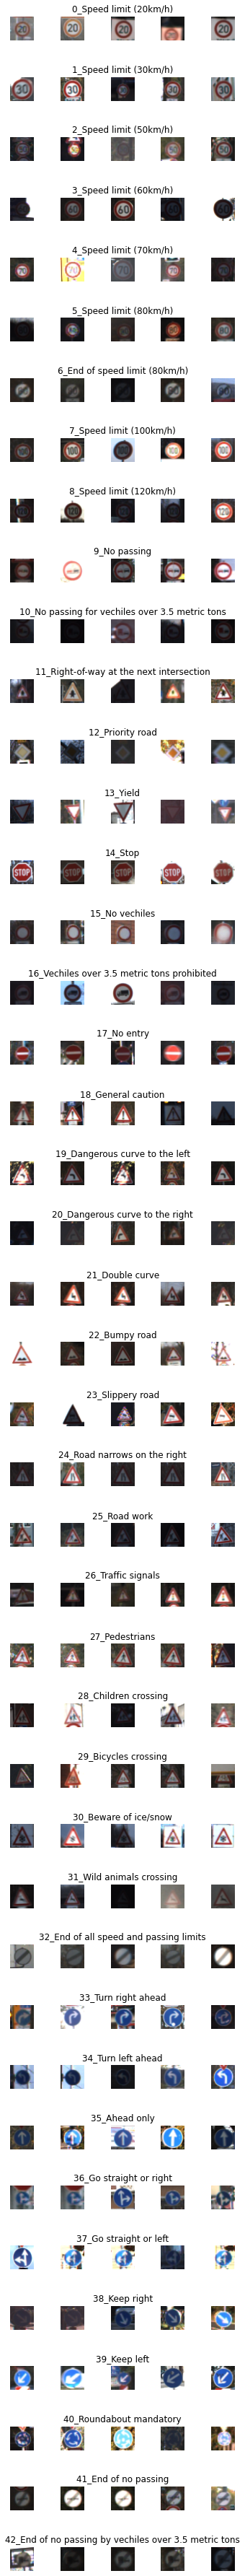

In [7]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))
            

## **PLOTTING NUMBER OF SAMPLES**

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

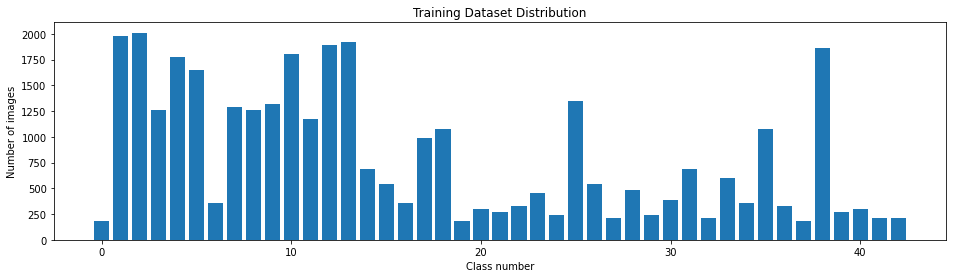

In [8]:
print(num_of_samples)
plt.figure(figsize = (16, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Training Dataset Distribution")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
1


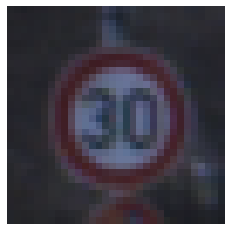

In [9]:
plt.imshow(X_train[4000])
plt.axis('off')
print(X_train[4000].shape)
print(y_train[4000])

In [10]:
def grayscale(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    return image

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

## **CONVERT TO GRAYSCALE**

(32, 32)


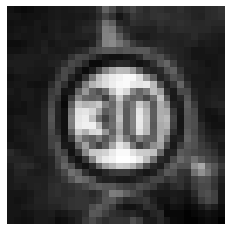

In [11]:
img = grayscale(X_train[4000])
plt.imshow(img, cmap = 'gray')
print(img.shape)

## **CONVERT TO HIGH CONTRAST IMAGE**

(32, 32)


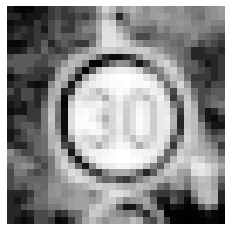

In [12]:
img = equalize(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
print(img.shape)

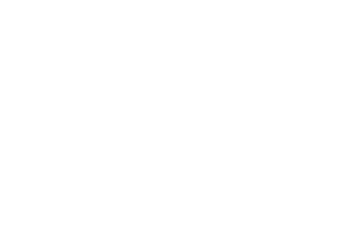

In [13]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [14]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [15]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                   zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

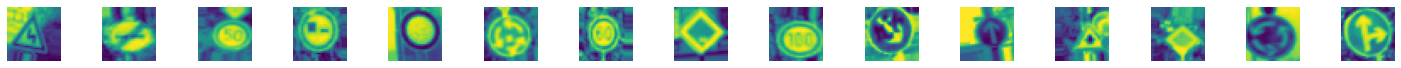

In [16]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [17]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

## **NEURAL NETWORK**

In [18]:
def neural_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(Conv2D(30, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    #model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [19]:
model = neural_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 10, validation_data =(X_val, y_val), shuffle = 1)

<ipython-input-20-4b93fad8b834>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 10, validation_data =(X_val, y_val), shuffle = 1)


Epoch 1/10
 696/2000 [=========>....................] - ETA: 13:30 - loss: 1.7064 - accuracy: 0.5147

2000/2000 [==============================] - 448s 222ms/step - loss: 1.7064 - accuracy: 0.5147 - val_loss: 0.3973 - val_accuracy: 0.8642


In [22]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test Score', score[0])
print('Test Accuracy', score[1])

395/395 [==============================] - 39s 98ms/step - loss: 0.4038 - accuracy: 0.8707
Test Score 0.4037741720676422
Test Accuracy 0.8707046508789062


## **PREDICTING TRAFFIC SIGNS INPUT BY USER**

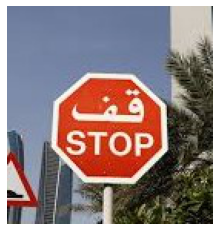

In [45]:
import requests
from PIL import Image
url = 'https://i.ibb.co/xMLwh0C/test-image.jpg'
r = requests.get(url, stream=True)
image = Image.open(r.raw)
plt.axis('off')
plt.imshow(image, cmap=plt.get_cmap('gray'))

(32, 32)


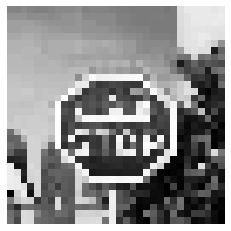

In [46]:
img = np.asarray(image)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [47]:
prediction = np.argmax(model.predict(img),axis=1)

##print("predicted sign: "+ prediction )

1/1 [==============================] - 0s 25ms/step


predicted sign: 14
predicted sign: Stop


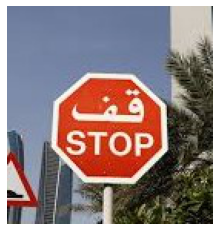

In [48]:
pred = int(prediction)
plt.imshow(image)
plt.axis('off')

for num, name in data.iteritems():
  name = name.values
  print("predicted sign: "+ str(name[pred]))